<a href="https://colab.research.google.com/github/GPhMorin/geneo/blob/main/examples/kinship_clustermap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kinship computation and clustering

This script computes pairwise kinship coefficients of the probands from the **genea140** dataset and plots a `clustermap` of kinship coefficients using Seaborn, inspired by figure 2 of [the following article](https://doi.org/10.1126/science.abi8264):
> Wohns, A. W., Wong, Y., Jeffery, B., Akbari, A., Mallick, S., Pinhasi, R., ... & McVean, G. (2022). A unified genealogy of modern and ancient genomes. *Science, 375*(6583), eabi8264.

In [ ]:
!python --version

Python 3.10.12


The GENEO toolkit will be used for loading the datasets, identifying the probands, and computing the kinship coefficients.

In [ ]:
%pip install https://github.com/GPhMorin/geneo/archive/main.zip

     \ 642.4 kB 6.4 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


The GENEO toolkit makes extensive use of Pandas dataframes, in this case, for the pairwise kinship coefficients and for the **pop140** dataset. Seaborn will be used for plotting.

In [ ]:
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.patches import Patch
import seaborn as sns
import geneo as gen

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [ ]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [ ]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
...,...,...
135,443161,Quebec
136,443159,Quebec
137,443165,Quebec
138,443167,Quebec


Now let's compute the pairwise kinship coefficients. On a recent computer, it should take just a few seconds to run the next line, especially if you have OpenMP detected during the toolkit's installation.

In [ ]:
phi = gen.phi(genea140)

The minimum non-null value will be used for plotting the color bar.

In [ ]:
min_phi = phi[phi != 0].min().min()
min_phi

2.384185791015625e-07

In another situation where the genealogies are bigger, you can run `gen.phi(genea140, compute=False)` to get information about the minimum RAM required.

In [ ]:
gen.phi(genea140, compute=False)

You will require at least 2.84 GB of RAM.


Let's create a dictionary to easily get the corresponding population of an individual.

In [ ]:
ind_to_pop = {ind: pop for index, (ind, pop) in pop140.iterrows()}
ind_to_pop

{409682: 'Saguenay',
 409687: 'Saguenay',
 868387: 'Saguenay',
 717537: 'Saguenay',
 302711: 'Saguenay',
 302716: 'Saguenay',
 868572: 'Saguenay',
 717634: 'Saguenay',
 409808: 'Saguenay',
 718567: 'Saguenay',
 677273: 'Saguenay',
 717709: 'Saguenay',
 302717: 'Saguenay',
 219947: 'Saguenay',
 288708: 'Saguenay',
 454422: 'Saguenay',
 302718: 'Saguenay',
 218089: 'Saguenay',
 302710: 'Saguenay',
 217891: 'Saguenay',
 288764: 'Saguenay',
 453612: 'Saguenay',
 408319: 'Gaspesia-Acadian',
 408480: 'Gaspesia-Acadian',
 408920: 'Gaspesia-Acadian',
 408926: 'Gaspesia-Acadian',
 408475: 'Gaspesia-Loyalist',
 408477: 'Gaspesia-Loyalist',
 408790: 'Gaspesia-Loyalist',
 409098: 'Gaspesia-Loyalist',
 409100: 'Gaspesia-Loyalist',
 409032: 'Gaspesia-Loyalist',
 408992: 'Gaspesia-Loyalist',
 409031: 'Gaspesia-Loyalist',
 409215: 'Gaspesia-Loyalist',
 409266: 'Gaspesia-Loyalist',
 409437: 'Gaspesia-Loyalist',
 409434: 'Gaspesia-Loyalist',
 409422: 'Gaspesia-Loyalist',
 409349: 'Gaspesia-Loyalist',
 4

Here's a dictionary to convert a population to its corresponding abbreviation.

In [ ]:
population_to_pop = {
    'Gaspesia-Acadian': 'ACA',
    'Gaspesia-FrenchCanadian': 'GFC',
    'Gaspesia-Loyalist': 'LOY',
    'Montreal': 'MON',
    'NorthShore': 'NS',
    'Quebec': 'QUE',
    'Saguenay': 'SAG'
}

Now, a dictionary to get the color of a corresponding abbreviation.

In [ ]:
pop_to_color = {
    'ACA': 'red',
    'GFC': 'purple',
    'LOY': 'lime',
    'MON': 'orange',
    'NS': 'cyan',
    'QUE': 'blue',
    'SAG': 'darkgreen',
}

Let's extract the color of each proband.

In [ ]:
pro = gen.pro(genea140)
pops = [ind_to_pop[ind] for ind in pro]
colors = [pop_to_color[population_to_pop[pop]] for pop in pops]
colors

['darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'purple',
 'red',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'lime',
 'lime',
 'red',
 'purple',
 'red',
 'red',
 'lime',
 'lime',
 'red',
 'red',
 'red',
 'purple',
 'red',
 'purple',
 'red',
 'purple',
 'purple',
 'lime',
 'lime',
 'lime',
 'red',
 'purple',
 'purple',
 'red',
 'red',
 'red',
 'red',
 'purple',
 'red',
 'lime',
 'lime',
 'red',
 'red',
 'red',
 'red',
 'lime',
 'red',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'orange',
 'orange',
 'orange',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'orange',
 'orange',
 'orange',
 'orange',
 'orange',
 'orange',

Instead of using the classical Euclidean distance, a modified version of cosine distance (1 - cosine similarity) is used where the diagonal values are ignored.

In [ ]:
def modified_cosine_distance(similarity_matrix):
    distances = np.zeros_like(similarity_matrix)
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            dot_product = 0
            norm_i = 0
            norm_j = 0
            # Calculate dot product and norms over all elements except i and j
            for k in range(len(similarity_matrix)):
                if k == i or k == j:
                    continue
                dot_product += similarity_matrix[i, k] * similarity_matrix[j, k]
                norm_i += similarity_matrix[i, k] ** 2
                norm_j += similarity_matrix[j, k] ** 2
            # Take square root outside of the loop
            norm_i = np.sqrt(norm_i)
            norm_j = np.sqrt(norm_j)
            # Calculate distance based on norms
            if norm_i == 0 or norm_j == 0:
                distances[i, j] = 1.0
            else:
                distances[i, j] = 1 - (dot_product / (norm_i * norm_j))
            distances[j, i] = distances[i, j]  # Symmetric assignment
    # Normalize by max distance
    max_distance = np.max(distances)
    distances /= max_distance
    return distances

In [ ]:
dist = modified_cosine_distance(phi.to_numpy())
dist[:5, :5]

array([[0.        , 0.50089624, 0.04861951, 0.05033278, 0.04658014],
       [0.50089624, 0.        , 0.49000471, 0.50501527, 0.52707295],
       [0.04861951, 0.49000471, 0.        , 0.00444049, 0.00695687],
       [0.05033278, 0.50501527, 0.00444049, 0.        , 0.0038146 ],
       [0.04658014, 0.52707295, 0.00695687, 0.0038146 , 0.        ]])

The following mask will remove the values of the lower triangle, including the diagonal.

In [ ]:
n = phi.shape[0]
mask = np.zeros((n, n), dtype=bool)
Z = hierarchy.linkage(squareform(dist), method='average', optimal_ordering=True)
ordering = hierarchy.leaves_list(Z)
for i in range(n):
    for j in range(n):
        if i >= j:
            mask[ordering[i], ordering[j]] = True
mask

array([[ True, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False,  True,  True],
       [ True, False,  True, ..., False,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True, False, False, ..., False,  True, False],
       [ True, False, False, ..., False,  True,  True]])

Finally, let's see the results.

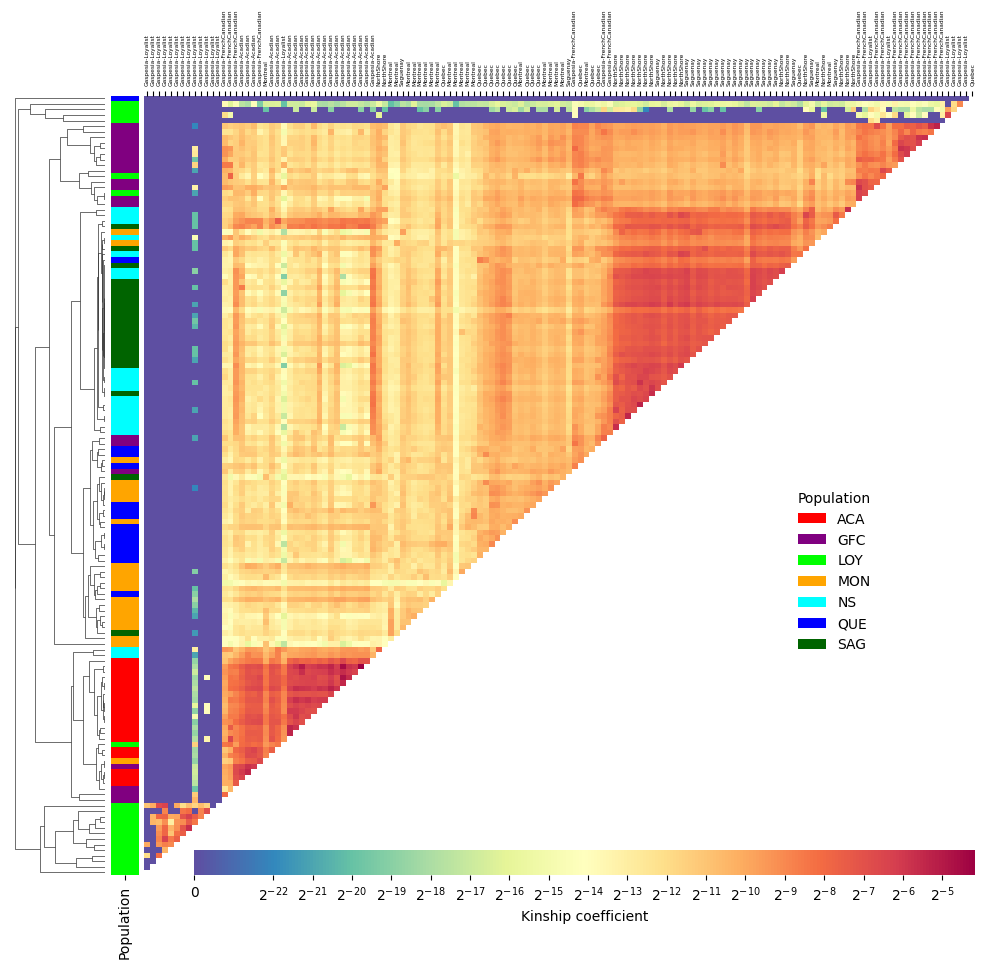

In [ ]:
cm = sns.clustermap(phi,
                    mask=mask,
                    cmap='Spectral_r',
                    row_colors=colors,
                    xticklabels=pops,
                    yticklabels=False,
                    cbar_kws={'label': 'Kinship coefficient',
                              'orientation': 'horizontal'},
                    dendrogram_ratio=(.1, 0),
                    figsize=(10, 10),
                    norm=SymLogNorm(linthresh=min_phi, base=2),
                    row_linkage=Z,
                    col_linkage=Z)

# Invert the x-axis
cm.ax_heatmap.invert_xaxis()

# Colorbar
cm.ax_cbar.yaxis.set_ticks_position('left')
cm.ax_cbar.yaxis.set_label_position('left')
x0, y0, w0, h0 = cm.cbar_pos
x1, y1, w1, h1 = cm.ax_heatmap.get_position().bounds
cm.ax_cbar.set_position([x1 + w0, y1, w1 - w0, w0 / 2])

# Add a label to the row colors
cm.ax_row_colors.set_xticks([0.5])
cm.ax_row_colors.set_xticklabels(['Population'], rotation=90)

# Move the xticklabels to the top
cm.ax_heatmap.xaxis.set_ticks_position('top')
cm.ax_heatmap.xaxis.set_label_position('top')
cm.ax_heatmap.xaxis.set_tick_params(rotation=90, labelsize=720*w1/phi.shape[0])

# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop) for pop, color in pop_to_color.items()]

# Add the legend to the plot
cm.ax_heatmap.legend(handles=legend_elements,
                     title='Population',
                     bbox_to_anchor=(w1, h1 / 2),
                     loc='center',
                     frameon=False)
plt.show()